In [1]:
import os
import numpy as np
import pandas as pd
from numpy.random import shuffle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

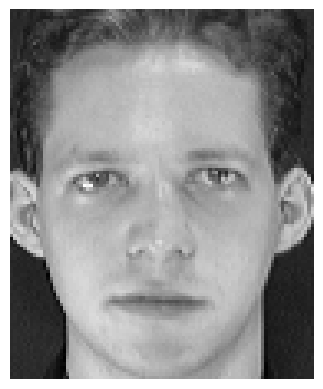

In [2]:
import cv2
import matplotlib.pyplot as plt

def read_pgm(file_path):
    return cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

def show_image(image_data):
    plt.imshow(image_data, cmap='gray')
    plt.axis('off')  # Hide axis labels
    plt.show()

file_path = f'/kaggle/input/att-images/ATT images/s1/1.pgm'
image_data = read_pgm(file_path)
show_image(image_data)

In [3]:
image_data.shape

(112, 92)

In [4]:
def get_data(path_data='/kaggle/input/att-images/ATT images', test_size=0.2, is_shuffle=True):
    folders = [f's{i+1}' for i in range(40)]
    X, y = [], []

    for i in range(1, 41):
        path = path_data + f'/s{i}'
        files = os.listdir(path)
        num_files = len(files)

        if is_shuffle:
            files = shuffle(files)

        for file in os.listdir(path):
            path = path_data + f'/s{i}/' + file
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            pixels = np.reshape(image, [1, image.shape[0] * image.shape[1]])
            pixels = np.asarray(pixels)

            if len(X) == 0:
                X = pixels
            else:
                X = np.vstack([X, pixels])
            y.append(f's{i}')

    return X, np.asarray(y)

In [5]:
X, y = get_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
n_components_pca = 50
pca = PCA(n_components=n_components_pca,random_state=42 ,svd_solver='randomized')
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

In [7]:
predictions = {}

# Euclidean

In [8]:
y_pred = []
for i in range(80):
    min_ = np.argmin(np.sqrt(np.sum((X_train_reduced - X_test_reduced[i])**2,axis=1)))
    y_pred.append(y_train[min_])

In [9]:
predictions['euclidean'] = y_pred

In [10]:
from sklearn.model_selection import KFold
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

****

**Chọn trường hợp accuracy của logistic model khác 1**

In [11]:
lr = LogisticRegression()
lr.fit(X_train_reduced, y_train)
y_pred = lr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# # One-hot encoding for probability calculation (adapt if necessary)
# y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
# y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)

accuracy: 1.0
recall: 1.0
precision: 1.0
f1-score: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Random Forest

In [12]:
prediction_results = {}

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

**Normal**

In [14]:
rfr = RandomForestClassifier()
rfr.fit(X_train_reduced,y_train)
y_pred = rfr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# # One-hot encoding for probability calculation (adapt if necessary)
# y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
# y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)

accuracy: 0.9625
recall: 0.9513888888888888
precision: 0.9398148148148147
f1-score: 0.9386243386243385


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Tunning**

In [15]:
import optuna


def objective(trial):
    hyperparams = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 32),
        'random_state': trial.suggest_categorical('random_state', [42]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32),
        'n_jobs': -1
    }

    model = RandomForestClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced,
                             y_train, cv=kf, scoring='accuracy')
    return np.mean(scores)

In [16]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

[I 2024-02-24 02:02:01,650] A new study created in memory with name: no-name-5ece4f79-977b-42b7-aac4-89555c6a2e4b
[I 2024-02-24 02:02:07,341] Trial 0 finished with value: 0.721875 and parameters: {'n_estimators': 573, 'max_depth': 14, 'min_samples_split': 9, 'random_state': 42, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.721875.
[I 2024-02-24 02:02:11,759] Trial 1 finished with value: 0.696875 and parameters: {'n_estimators': 460, 'max_depth': 30, 'min_samples_split': 24, 'random_state': 42, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.721875.
[I 2024-02-24 02:02:14,716] Trial 2 finished with value: 0.71875 and parameters: {'n_estimators': 303, 'max_depth': 12, 'min_samples_split': 26, 'random_state': 42, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.721875.
[I 2024-02-24 02:02:20,864] Trial 3 finished with value: 0.796875 and parameters: {'n_estimators': 586, 'max_depth': 41, 'min_samples_split': 8, 'random_state': 42, 'min_samples_leaf': 6}. Best is tria

Best params found : {'n_estimators': 288, 'max_depth': 27, 'min_samples_split': 3, 'random_state': 42, 'min_samples_leaf': 1}


0.9875

In [17]:
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['random forest'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# # One-hot encoding for probability calculation (adapt if necessary)
# y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
# y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)

accuracy: 0.9875
recall: 0.9722222222222222
precision: 0.9629629629629629
f1-score: 0.9666666666666666


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


****

# Gassian NB

**Pre-tunning**

In [18]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_reduced, y_train)

y_pred = gnb.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
# y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovr')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)


accuracy: 0.9625
recall: 0.9444444444444444
precision: 0.9375
f1-score: 0.9358465608465608


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Tunning**

In [19]:
def objective(trial):
    hyperparams = {
        'var_smoothing': trial.suggest_float('var_smoothing', 1e-9, 1e-4, log = True)
    }
    
    model = GaussianNB(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [20]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = GaussianNB(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['logistic regression'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# # One-hot encoding for probability calculation (adapt if necessary)
# y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
# y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)

[I 2024-02-24 02:07:46,169] A new study created in memory with name: no-name-dc50602a-5e4c-44f2-9820-b0d0a336eb5f
[I 2024-02-24 02:07:46,194] Trial 0 finished with value: 0.75 and parameters: {'var_smoothing': 4.548589515576724e-06}. Best is trial 0 with value: 0.75.
[I 2024-02-24 02:07:46,218] Trial 1 finished with value: 0.75 and parameters: {'var_smoothing': 1.2884488097346021e-09}. Best is trial 0 with value: 0.75.
[I 2024-02-24 02:07:46,241] Trial 2 finished with value: 0.75 and parameters: {'var_smoothing': 2.066183850620797e-09}. Best is trial 0 with value: 0.75.
[I 2024-02-24 02:07:46,265] Trial 3 finished with value: 0.75 and parameters: {'var_smoothing': 7.0748282048675225e-06}. Best is trial 0 with value: 0.75.
[I 2024-02-24 02:07:46,289] Trial 4 finished with value: 0.75 and parameters: {'var_smoothing': 2.319109223642912e-07}. Best is trial 0 with value: 0.75.
[I 2024-02-24 02:07:46,312] Trial 5 finished with value: 0.7625 and parameters: {'var_smoothing': 7.01823731967147

Best params found : {'var_smoothing': 9.933226827304191e-05}
accuracy: 0.9625
recall: 0.9444444444444444
precision: 0.9375
f1-score: 0.9358465608465608


****

# Logistic Regression

**Normal**

In [21]:
lr = LogisticRegression()
lr.fit(X_train_reduced, y_train)
y_pred = lr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# # One-hot encoding for probability calculation (adapt if necessary)
# y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
# y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)

accuracy: 1.0
recall: 1.0
precision: 1.0
f1-score: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Tunning**

In [22]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')


def objective(trial):
    hyperparams = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg', 'saga']),
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'multi_class': trial.suggest_categorical('multi_class', ['ovr']),
        'C': trial.suggest_loguniform("C", 1e-3, 1e3),
        'n_jobs': -1
    }

    model = LogisticRegression(**hyperparams)
    scores = cross_val_score(model, X_train_reduced,
                             y_train, cv=kf, scoring='accuracy')
    return np.mean(scores)

In [23]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 200)
best_params = study.best_params
print("Best params found :", best_params)

final_model = LogisticRegression(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['logistic regression'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

[I 2024-02-24 02:07:49,347] A new study created in memory with name: no-name-d4a91587-6b0e-4b12-8402-2c5f4509c1e9
[I 2024-02-24 02:07:50,301] Trial 0 finished with value: 0.80625 and parameters: {'solver': 'saga', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.004754591112777707}. Best is trial 0 with value: 0.80625.
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACH

Best params found : {'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.15716625446721771}
accuracy: 1.0
recall: 1.0
precision: 1.0
f1-score: 1.0
roc_auc:  1.0


In [24]:
# lr = LogisticRegression(multi_class='ovr', solver='liblinear')
# lr.fit(X_train_reduced, y_train)
# y_pred = lr.predict(X_test_reduced)

# KNN Classifier

**Normal**

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_reduced, y_train)
y_pred = knn.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# # One-hot encoding for probability calculation (adapt if necessary)
# y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
# y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)


accuracy: 0.9125
recall: 0.9375
precision: 0.9143518518518517
f1-score: 0.9068783068783068


**Tunning**

In [26]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    hyperparams = {
        'n_neighbors': trial.suggest_int("n_neighbors", 5, 100),
        'weights' : trial.suggest_categorical("weights", ["uniform", "distance"]),
        'metric' : trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski"]),
        'algorithm':trial.suggest_categorical('algorithm',['auto', 'ball_tree', 'kd_tree', 'brute']),
        'n_jobs': -1
    }
    
    # Create KNN model with tuned hyperparameters
    model = KNeighborsClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [27]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 200)
best_params = study.best_params
print("Best params found :", best_params)

final_model =KNeighborsClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['KNN'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# # One-hot encoding for probability calculation (adapt if necessary)
# y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
# y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)

[I 2024-02-24 02:15:27,796] A new study created in memory with name: no-name-1188692c-4f00-464c-8d02-7cb069431ec9
[I 2024-02-24 02:15:27,878] Trial 0 finished with value: 0.571875 and parameters: {'n_neighbors': 98, 'weights': 'distance', 'metric': 'minkowski', 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.571875.
[I 2024-02-24 02:15:27,910] Trial 1 finished with value: 0.0875 and parameters: {'n_neighbors': 65, 'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'brute'}. Best is trial 0 with value: 0.571875.
[I 2024-02-24 02:15:27,996] Trial 2 finished with value: 0.153125 and parameters: {'n_neighbors': 53, 'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.571875.
[I 2024-02-24 02:15:28,087] Trial 3 finished with value: 0.071875 and parameters: {'n_neighbors': 80, 'weights': 'uniform', 'metric': 'euclidean', 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.571875.
[I 2024-02-24 02:15:28,108] Trial 4 finished with

Best params found : {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'kd_tree'}
accuracy: 0.9875
recall: 0.9930555555555556
precision: 0.9930555555555556
f1-score: 0.9920634920634921


# Support Vector Machine 

**Normal**

In [28]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(X_train_reduced, y_train)
y_pred = svm.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# Assuming 'label_' prefix for clarity
y_test_onehot = pd.get_dummies(y_test, prefix='label_')
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
                              average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 1.0
recall: 1.0
precision: 1.0
f1-score: 1.0
roc_auc:  1.0


**Tunning**

In [29]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    hyperparams = {
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
        'C': trial.suggest_loguniform('C', 1e-5, 1e5),
        'gamma': trial.suggest_loguniform('gamma', 1e-5, 1e5),
        # 'degree': trial.suggest_int('degree', 2, 5),  # for polynomial kernel
        'tol': trial.suggest_loguniform('tol', 1e-4, 1e-2),
        'shrinking': trial.suggest_categorical('shrinking', [True, False]),
    }
    
    # Create KNN model with tuned hyperparameters
    model = SVC(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [30]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = SVC(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['svc'] = list(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# Assuming 'label_' prefix for clarity
y_test_onehot = pd.get_dummies(y_test, prefix='label_')
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
                              average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

[I 2024-02-24 02:15:40,074] A new study created in memory with name: no-name-bdc01c70-fb78-4f98-aeec-fda2d1501d30
[I 2024-02-24 02:15:40,151] Trial 0 finished with value: 0.0 and parameters: {'kernel': 'rbf', 'C': 0.003749889933767837, 'gamma': 0.003821802387381811, 'tol': 0.0015162113198133366, 'shrinking': True}. Best is trial 0 with value: 0.0.
[I 2024-02-24 02:15:40,220] Trial 1 finished with value: 0.859375 and parameters: {'kernel': 'poly', 'C': 0.00030772237806172566, 'gamma': 1.437811437603048, 'tol': 0.0002502038255743148, 'shrinking': True}. Best is trial 1 with value: 0.859375.
[I 2024-02-24 02:15:40,284] Trial 2 finished with value: 0.859375 and parameters: {'kernel': 'poly', 'C': 7206.8542880638615, 'gamma': 0.3355691454118639, 'tol': 0.0017032032139219302, 'shrinking': True}. Best is trial 1 with value: 0.859375.
[I 2024-02-24 02:15:40,343] Trial 3 finished with value: 0.946875 and parameters: {'kernel': 'linear', 'C': 0.00010023080976677891, 'gamma': 171.64644132028351, 

Best params found : {'kernel': 'linear', 'C': 0.00010023080976677891, 'gamma': 171.64644132028351, 'tol': 0.0007038171585062275, 'shrinking': True}
accuracy: 1.0
recall: 1.0
precision: 1.0
f1-score: 1.0
roc_auc:  1.0


# Decision Tree

**Normal**

In [31]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_reduced, y_train)
y_pred = dt.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# Assuming 'label_' prefix for clarity
y_test_onehot = pd.get_dummies(y_test, prefix='label_')
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
                              average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

svm = SVC(kernel='linear')
svm.fit(X_train_reduced, y_train)
y_pred = svm.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# # One-hot encoding for probability calculation (adapt if necessary)
# # Assuming 'label_' prefix for clarity
# y_test_onehot = pd.get_dummies(y_test, prefix='label_')
# y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
#                               average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)

accuracy: 0.6
recall: 0.55
precision: 0.5641666666666667
f1-score: 0.5229761904761905
roc_auc:  0.5452392744810545
accuracy: 1.0
recall: 1.0
precision: 1.0
f1-score: 1.0


**Tunning**

In [32]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')


def objective(trial):
    hyperparams = {
        "max_depth" : trial.suggest_int("max_depth", 2, 10),
        "min_samples_split" : trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 10),
        "criterion" : trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'random_state': trial.suggest_categorical('random_state', [42])
        

    }

    # Create KNN model with tuned hyperparameters
    model = DecisionTreeClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced,
                             y_train, cv=kf, scoring='accuracy')
    return np.mean(scores)

In [33]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = DecisionTreeClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['decison tree'] = list(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# # One-hot encoding for probability calculation (adapt if necessary)
# # Assuming 'label_' prefix for clarity
# y_test_onehot = pd.get_dummies(y_test, prefix='label_')
# y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
#                               average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)

[I 2024-02-24 02:15:48,131] A new study created in memory with name: no-name-651a97d8-efbe-4a55-84ac-9d1fee6509b2
[I 2024-02-24 02:15:48,264] Trial 0 finished with value: 0.434375 and parameters: {'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4, 'criterion': 'entropy', 'random_state': 42}. Best is trial 0 with value: 0.434375.
[I 2024-02-24 02:15:48,315] Trial 1 finished with value: 0.3375 and parameters: {'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 7, 'criterion': 'gini', 'random_state': 42}. Best is trial 0 with value: 0.434375.
[I 2024-02-24 02:15:48,439] Trial 2 finished with value: 0.20625 and parameters: {'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 1, 'criterion': 'entropy', 'random_state': 42}. Best is trial 0 with value: 0.434375.
[I 2024-02-24 02:15:48,483] Trial 3 finished with value: 0.15 and parameters: {'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 6, 'criterion': 'gini', 'random_state': 42}. Best is trial 0 wit

Best params found : {'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'entropy', 'random_state': 42}
accuracy: 0.6625
recall: 0.7476851851851852
precision: 0.7347222222222222
f1-score: 0.6736772486772487


Tuning rồi lưu kết quả tuning vào bên dưới

Tuning rồi lưu kết quả tuning vào bên dưới

In [34]:
predictions['lr'] = list(y_pred)

In [35]:
import json
with open("/kaggle/working/predict.json", "w") as json_file:
    json.dump(predictions, json_file)

In [36]:
prediction = {}